# Sparse/Partial SVD Reconstruction Error Benchmarks

Sparse SVD computations in Python have been benchmarked by Jake Vanderplas. 
https://jakevdp.github.io/blog/2012/12/19/sparse-svds-in-python/

His main focus was on timing of the SVD computations.  This benchmark concerns reconstruction error and aims to make a compelling argument for abandoning ARPACK for SVD computation due to it's poor performance. 


## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.linalg import qr
from numpy.random import random, RandomState
from scipy.sparse import csc_matrix

In [32]:

def err_svd(svdfunc, errfunc, N1, N2, P, sig, M, rseed=None, args=None, matfunc=np.asarray, **kwargs):
    if args is None:
        args = ()   
    err_svd = np.zeros((M,len(P)))
    if rseed:
        rng = RandomState(rseed)
    for i in range(M):
        if rseed:
            U,_ = qr(rng.rand(N1, len(sig)))
            V,_ = qr(rng.rand(N2, len(sig)))
        else:
            U = np.eye(N1, len(sig))
            V = np.eye(N2, len(sig))
        for j,p in enumerate(P):
            S = sig**p
            A = matfunc(np.dot(U,(S*V).T))
            try:
                u,s,vt = svdfunc(A,*args,**kwargs)
            except:
                print A.todense()
                raise

            try:
                err_svd[i,j] = errfunc(A,u,s,vt)
            except:
                print len(sig),s
                raise
    return err_svd

def fro_error(A,u,s,vt):
    return np.linalg.norm(A-np.dot(u,(s*vt.T).T))

def sing_error(A,u,s,vt):
    if len(s) < len(S):
        s = np.pad(s,len(S)-len(s),'constant', constant_values=0)
        s = np.sort(s)[:-(n+1):-1]


def compute_propack(N1, N2, P, sig, M, errfunc=fro_error, rseed=None):
    from pypropack import svdp
    print "computing svd error for propack..."
    return err_svd(svdp, errfunc, N1, N2, P, sig, M, k=len(sig), kmax=N2, rseed=rseed,
                 matfunc=csc_matrix)

def compute_arpack(N1, N2, P, sig, M, errfunc=fro_error, rseed=None):
    from scipy.sparse.linalg import svds
    print "computing svd error for arpack..."
    return err_svd(svds, errfunc, N1, N2, P, sig, M, k=len(sig), rseed=rseed, matfunc=csc_matrix)

def compute_svdlibc(N1, N2, P, sig, M, errfunc=fro_error, rseed=None):
    from sparsesvd import sparsesvd
    print "computing svd error for svdlibc..."
    return err_svd(sparsesvd, errfunc, N1, N2, P, sig, M, args=(len(sig),), rseed=rseed, matfunc=csc_matrix)

def compute_lapack(N1, N2, P, sig, M, errfunc=fro_error, rseed=None):
    from scipy.linalg import svd
    print "computing svd error for lapack..."
    return err_svd(svd, errfunc, N1, N2, P, sig, M, rseed=rseed, full_matrices=False)

## SVD

We consider rectangular matrices of the form,
$ A \in R^{N_1\times N_2}, $
where $N_1$ and $N_2$ will be relatively small for demonstration purposes.

The SVD gives,
$ A = U\Sigma V^T. $
We use both a trivial SVD with rectangular identity matrices for $U$ and $V$ and a non-trivial SVD with random orthogonal matrices.

We consider $A$ to have rank 3 and singular values,
$ \sigma_i = [10^p,1,.1^p], $
for $p = .25,.5, \ldots, 15.75, 16$.  The purpose of varying $p$ is to modulate the condition number of the matrix (or also the singular gap $\sigma_1 - \sigma_2$).

We run 1000 computations for each $p$ and each SVD function (we skip svdlibc for now because of errors). 

computing svd error for lapack...
computing svd error for lapack...
computing svd error for arpack...
computing svd error for arpack...
computing svd error for propack...
computing svd error for propack...


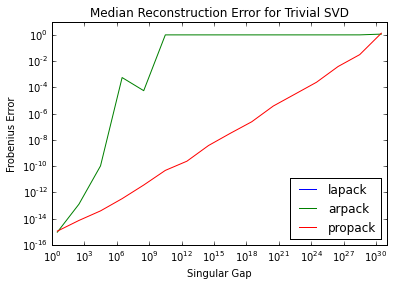

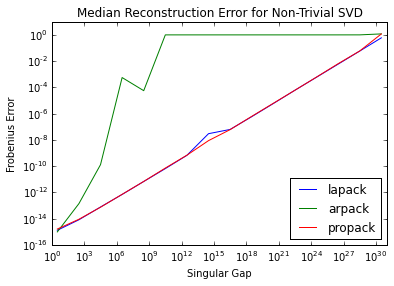

In [33]:
P = np.arange(.25,16.25)
sig = np.array([10,1,.1])
M = 1000
N1 = 25
N2 = 10
rseed = 123

SVDs = {
    'propack' : compute_propack,
    'arpack'  : compute_arpack,
#     'svdlibc' : compute_svdlibc,
    'lapack'  : compute_lapack
}

triv_svd_err = {}
svd_err = {}
for name, compute_func in SVDs.items():
    triv_svd_err[name] =  compute_func(N1,N2,P,sig,M)
    svd_err[name] =  compute_func(N1,N2,P,sig,M,rseed=rseed)    
    
fig, ax = plt.subplots(subplot_kw=dict(xscale='log', yscale='log'))
for name, err in triv_svd_err.items():
    try:
        ax.plot(100**P,np.median(err,axis=0),label=name)
    except:
        pass

ax.legend(loc=4);
ax.set_xlabel('Singular Gap');
ax.set_ylabel('Frobenius Error');
ax.set_title('Median Reconstruction Error for Trivial SVD');

fig, ax = plt.subplots(subplot_kw=dict(xscale='log', yscale='log'))
for name, err in svd_err.items():
    try:
        ax.plot(100**P,np.median(err,axis=0),label=name)
    except:
        pass

ax.legend(loc=4);
ax.set_xlabel('Singular Gap');
ax.set_ylabel('Frobenius Error');
ax.set_title('Median Reconstruction Error for Non-Trivial SVD');

## Conclusion

When using the identity matrices, the partial svd computations do not recover the trivial svd exactly so there is non-zero reconstruction error as a function of the condition number.  LAPACK does recover the SVD exactly with error equal to 0 and hence why it does not show up in the plot for reconstruction error.
 
Using the SVD computation based off ARPACK does incredibly poorly in reconstruction error, even with a trivial SVD computation.  For condition number around $10^6$, ARPACK's reconstruction error is already unacceptable.  PROPACK is much more stable in it's error growth.  

Comparing between the trivial and non-trivial, the curves for ARPACK and PROPACK are very similar (the main driving factor is condition number).  There is non-zero error in LAPACK's computation for the non-trvial SVD and PROPACK tracks LAPACK well.  

Basically, using ARPACK is very subpar with respect to reconstruction error.  Moreover, this is really not surprising since SciPy's svds function uses ARPACK to compute an eigendecomposition for $A^TA$, which has square the condition number of $A$.

PROPACK's svd appears to be a very suitable substitute for the SVD computation in SciPy.